# Trial-averaged temporal factors matched across day PAIRS, validated with cell assemblies

### maybe try showing that bias still exists and which factors it comes from

In [1]:
"""Functions for plotting tca decomp."""
import os
import flow
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import tensortools as tt
import seaborn as sns
import pandas as pd
from copy import deepcopy
from cascade import df
from cascade import tca
from cascade import paths

In [6]:
mouse='OA27'
trace_type='zscore_day'
method='ncp_bcd'
cs=''
warp=False
word='exclusion'

extra_col=4
alpha=0.6
plot_running=True
filetype='pdf'
verbose=False

"""
Plot TCA factors with trial metadata annotations for all days
and ranks/componenets for TCA decomposition ensembles.

Parameters:
-----------
mouse : str
    Mouse name.
trace_type : str
    dff, zscore, zscore_iti, zscore_day, deconvolved
method : str
    TCA fit method from tensortools
cs : str
    Cs stimuli to include, plus/minus/neutral, 0/135/270, etc. '' empty
    includes all stimuli
warp : bool
    Use traces with time-warped outcome.
extra_col : int
    Number of columns to add to the original three factor columns
alpha : float
    Value between 0 and 1 for transparency of markers
plot_running : bool
    Include trace of scaled (to plot max) average running speed during trial
verbose : bool
    Show plots as they are made.

Returns:
--------
Saves figures to .../analysis folder  .../factors annotated
"""

"\nPlot TCA factors with trial metadata annotations for all days\nand ranks/componenets for TCA decomposition ensembles.\n\nParameters:\n-----------\nmouse : str\n    Mouse name.\ntrace_type : str\n    dff, zscore, zscore_iti, zscore_day, deconvolved\nmethod : str\n    TCA fit method from tensortools\ncs : str\n    Cs stimuli to include, plus/minus/neutral, 0/135/270, etc. '' empty\n    includes all stimuli\nwarp : bool\n    Use traces with time-warped outcome.\nextra_col : int\n    Number of columns to add to the original three factor columns\nalpha : float\n    Value between 0 and 1 for transparency of markers\nplot_running : bool\n    Include trace of scaled (to plot max) average running speed during trial\nverbose : bool\n    Show plots as they are made.\n\nReturns:\n--------\nSaves figures to .../analysis folder  .../factors annotated\n"

In [25]:

pars = {'trace_type': trace_type, 'cs': cs, 'warp': warp}

days = flow.metadata.DateSorter.frommeta(mice=[mouse], tags=None)

# for day1 in days:
day1 = days[0]
day2 = days[1]
# days = flow.metadata.DateSorter.frommeta(mice=[mouse], tags=None)

#     for c, day1 in enumerate(days, 0):
#         try:
#             day2 = days[c+1]
#         except IndexError:
#             print('done.')
#             break

# load dirs
load_dir = paths.tca_path(mouse, 'pair', pars=pars, word=word)
tensor_path = os.path.join(load_dir, str(day1.mouse) + '_'
                           + str(day1.date) + '_' + str(day2.date)
                           + '_pair_decomp_' + str(trace_type)
                           + '.npy')
input_ids_path = os.path.join(load_dir, str(day1.mouse) + '_'
                           + str(day1.date) + '_' + str(day2.date)
                           + '_pair_ids_' + str(trace_type)
                           + '.npy')
meta_path = os.path.join(load_dir, str(day1.mouse) + '_' +
                         str(day1.date) + '_' + str(day2.date)
                         + '_df_pair_meta.pkl')
# if not os.path.isfile(tensor_path): continue
# if not os.path.isfile(meta_path): continue

# save dirs
save_dir = paths.tca_plots(mouse, 'pair', pars=pars, word=word)
save_dir = os.path.join(save_dir, 'factors annotated')
if not os.path.isdir(save_dir): os.mkdir(save_dir)
date_dir = os.path.join(save_dir, str(day1.date) + '_' + str(day2.date)
                        + ' ' + method)
if not os.path.isdir(date_dir): os.mkdir(date_dir)

# load your data
ensemble = np.load(tensor_path)
ensemble = ensemble.item()
meta = pd.read_pickle(meta_path)
orientation = meta['orientation']
trial_num = np.arange(0, len(orientation))
condition = meta['condition']
trialerror = meta['trialerror']
hunger = deepcopy(meta['hunger'])
speed = meta['speed']

# merge hunger and tag info for plotting hunger
tags = meta['tag']
hunger[tags == 'disengaged'] = 'disengaged'

# input_tensor, ids = np.load(input_tensor_path)
ids = np.load(input_ids_path)
    
# sort neuron factors by component they belong to most
sort_ensemble, my_sorts = tca._sortfactors(ensemble[method])

        
# for r in sort_ensemble.results:
r = 10
U = sort_ensemble.results[r][0].factors
U_ids = ids[my_sorts[r-1]]

In [26]:
print(np.shape(U.factors[0]))
print(np.shape(ids))
np.shape(my_sorts[9])
my_sorts[9]

(90, 10)
(90,)


array([17, 37, 50, 25, 52, 58, 59, 21, 73, 83, 42, 19, 43, 44, 31, 63, 22,
       68, 29, 64, 24, 87, 16, 14, 28, 11, 39, 72, 26, 40, 55, 53, 70, 20,
       61, 69, 66, 78, 32, 47,  7,  0, 18, 45, 82,  9, 30, 76, 84, 15, 41,
       48, 89, 51, 27, 85, 33, 36,  4, 12,  6, 23, 71, 88, 46, 75, 74,  2,
       81, 56,  1, 65, 49, 34, 86, 67, 62,  8, 79, 77,  5, 38, 57, 54, 10,
       13, 60,  3, 80, 35])

### trying to identify condition responsivity followed by matching for temporal factor shape

[1, 8]
[0.5445529774420482, 0.9347945459862347]


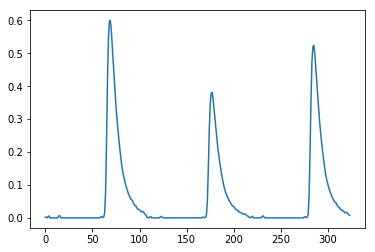

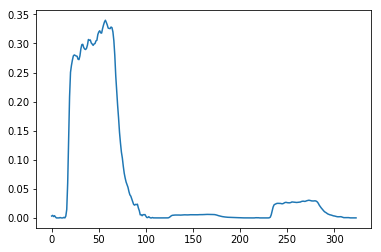

In [27]:
# day one
# get your seed component
plus_comps = []
plus_comps_mean = []
tri_comp = []
for i in range(U.rank):
    plus_trials = np.nanmean(U.factors[2][condition == 'plus', i])
    minus_trials = np.nanmean(U.factors[2][condition == 'minus', i])
    neutral_trials = np.nanmean(U.factors[2][condition == 'neutral', i])
    other_trials = np.nanmean(U.factors[2][condition != 'plus', i])
    
    if (plus_trials > minus_trials) & (plus_trials > neutral_trials) & (plus_trials > other_trials):
        plus_comps.append(i)
        plus_comps_mean.append(plus_trials)
        
        plt.figure()
        p = (U.factors[1][:, i]
             *plus_trials
             *np.mean(U.factors[0][U.factors[0][:, i] > 0, i]))
        m = (U.factors[1][:, i]
             *minus_trials
             *np.mean(U.factors[0][U.factors[0][:, i] > 0, i]))
        n = (U.factors[1][:, i]
             *neutral_trials
             *np.mean(U.factors[0][U.factors[0][:, i] > 0, i]))
        triplet = np.concatenate((p,m,n))
        tri_comp.append(triplet)
        plt.plot(triplet)
        
print(plus_comps)
print(plus_comps_mean)
plus_component_to_match = 8 # selected manually
# the following day

# starting_factor = (U.factors[1][:, plus_component_to_match]
#                    *plus_comps_mean[plus_comps == plus_component_to_match]
#                    *np.mean(U.factors[0][U.factors[0][:, plus_component_to_match] > 0, plus_component_to_match]))
starting_factor = tri_comp[1]                                                                                                       
starting_factor_1 = starting_factor                                                                                                           

array([  54,  118,   83,  181,   56,   80,   76,   29,  140,   51,  194,
        188,  214,  129, 1506,   90,  211,    9,  235,    7,  186,  131,
         91,  497,  190,  177,   23,  225,  220,   14,  147,   25,  170,
        229])

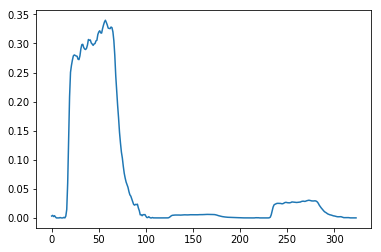

In [28]:
plt.plot(starting_factor)
U_ids[U.factors[0][:, plus_component_to_match] > 0.05]
# U.factors[0][:, plus_component_to_match] == 0

In [29]:
# plt.plot(U.factors[1][:, [0, 3, 5, 9]])
aligned_temp_fac = np.zeros((len(starting_factor),len(days)))
aligned_temp_fac[:, 0] = starting_factor
aligned_cell_ids = []
aligned_cell_fac = []
aligned_cell_ids.append(U_ids[U.factors[0][:, plus_component_to_match] > 0])
aligned_cell_fac.append(U.factors[0][U.factors[0][:, plus_component_to_match] > 0, plus_component_to_match])
dud = starting_factor
dud[:] = np.nan
# for c, day2 in enumerate(days[1:]):
    
for c, day1 in enumerate(days[1:], 0):
    try:
        day2 = days[c+2]
    except IndexError:
        print('done.')
        break
            
    # load dir
    load_dir = paths.tca_path(mouse, 'pair', pars=pars, word=word)
    tensor_path = os.path.join(load_dir, str(day1.mouse) + '_'
                               + str(day1.date) + '_' + str(day2.date)
                               + '_pair_decomp_' + str(trace_type)
                               + '.npy')
    input_ids_path = os.path.join(load_dir, str(day1.mouse) + '_'
                               + str(day1.date) + '_' + str(day2.date)
                               + '_pair_ids_' + str(trace_type)
                               + '.npy')
    meta_path = os.path.join(load_dir, str(day1.mouse) + '_' +
                             str(day1.date) + '_' + str(day2.date)
                             + '_df_pair_meta.pkl')
    
    # load your data
    ensemble2 = np.load(tensor_path)
    ensemble2 = ensemble2.item()
    meta = pd.read_pickle(meta_path)
    orientation = meta['orientation']
    trial_num = np.arange(0, len(orientation))
    condition = meta['condition']
    trialerror = meta['trialerror']
    hunger = deepcopy(meta['hunger'])
    speed = meta['speed']

    # merge hunger and tag info for plotting hunger
    tags = meta['tag']
    hunger[tags == 'disengaged'] = 'disengaged'

    # input_tensor, ids = np.load(input_tensor_path)
    ids = np.load(input_ids_path)

    # sort neuron factors by component they belong to most
    sort_ensemble, my_sorts = tca._sortfactors(ensemble2[method])

    # for r in sort_ensemble.results:
    r = 10
    V = sort_ensemble.results[r][0].factors
    V_ids = ids[my_sorts[r-1]]
                            
    # get your best matched component from plus components
    plus_comps2 = []
    plus_comps_mean2 = []
    tri_comp2 = []
    for i in range(U.rank):
        plus_trials = np.nanmean(V.factors[2][condition == 'plus', i])
        minus_trials = np.nanmean(V.factors[2][condition == 'minus', i])
        neutral_trials = np.nanmean(V.factors[2][condition == 'neutral', i])
        other_trials = np.nanmean(V.factors[2][condition != 'plus', i])

        if (plus_trials > minus_trials) & (plus_trials > neutral_trials) & (plus_trials > other_trials):
            plus_comps2.append(i)
            plus_comps_mean2.append(plus_trials)
            p = (V.factors[1][:, i]
             *plus_trials
             *np.mean(V.factors[0][V.factors[0][:, i] > 0, i]))
            m = (V.factors[1][:, i]
             *minus_trials
             *np.mean(V.factors[0][V.factors[0][:, i] > 0, i]))
            n = (V.factors[1][:, i]
             *neutral_trials
             *np.mean(V.factors[0][V.factors[0][:, i] > 0, i]))
            triplet = np.concatenate((p,m,n))
#             plt.figure()
#             plt.plot(triplet)
            tri_comp2.append(triplet)
            
    if not plus_comps2:
        aligned_temp_fac[:, c+1] = dud
        continue
        # add in the mean of only the plus trials on days when all three stim are not shown
#         for i in range(U.rank):
#             plus_trials = np.nanmean(V.factors[2][condition == 'plus', i])
#             plus_comps2.append(i)
#             plus_comps_mean2.append(plus_trials)

    norm_search = []
#     for i in plus_comps2:
    for i in range(len(plus_comps2)):
#         comp_factor = (V.factors[1][:, i]
#                        *plus_comps_mean2[plus_comps2 == i]
#                        *np.mean(V.factors[0][V.factors[0][:, i] > 0, i]))
        comp_factor = tri_comp2[i]
        # normalize traces before comparison
        norm_search.append(np.linalg.norm(comp_factor-starting_factor))

    best_factor = plus_comps2[np.argmin(norm_search)]
#     starting_factor = (V.factors[1][:, best_factor]
#                        *plus_comps_mean2[plus_comps2 == best_factor]
#                        *np.mean(V.factors[0][V.factors[0][:, best_factor] > 0, best_factor]))
#     starting_factor = tri_comp[best_factor]
    starting_factor = tri_comp2[np.argmin(norm_search)]
    aligned_cell_ids.append(V_ids[V.factors[0][:, best_factor] > 0])
    aligned_cell_fac.append(V.factors[0][V.factors[0][:, best_factor] > 0, best_factor])
    aligned_temp_fac[:, c+1] = starting_factor


/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice
/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice
/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice
/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: RuntimeWarning: Mean of empty slice
/Users/kelly_mcguire/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: RuntimeWarning: Mean of empty slice
/Users/kelly_mcguire/anaconda3/l

done.


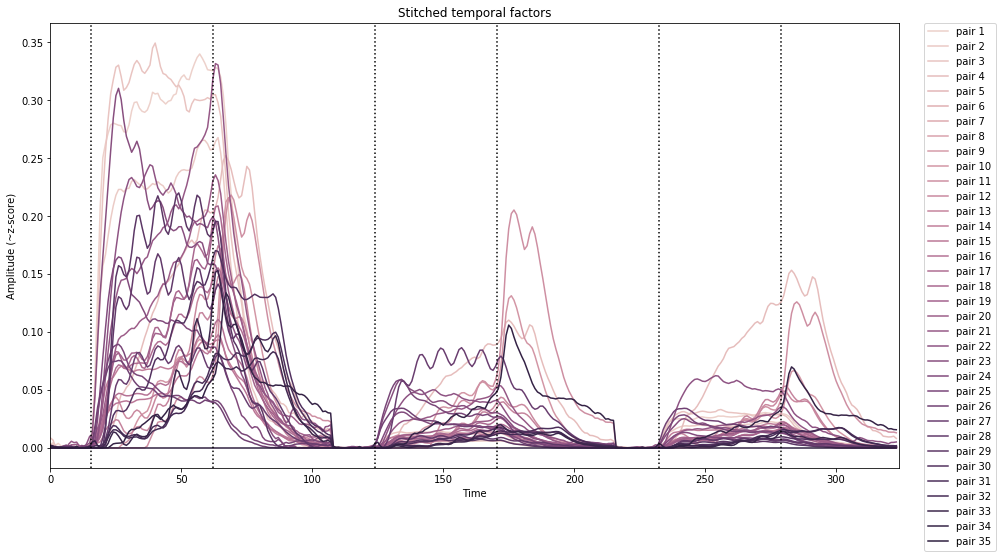

In [57]:
cmap = sns.color_palette(sns.cubehelix_palette(len(days)))
plt.figure(figsize=(14,8))
for c in range(len(days)):
    plt.plot(aligned_temp_fac[:,c],color=cmap[c], label=('pair ' +str(c+1)))
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=0.)
ylim = plt.ylim()
num = 15.5
plt.plot([num,num], ylim,':k')
plt.plot([num*4,num*4], ylim, ':k')
plt.plot([num*8,num*8], ylim,':k')
plt.plot([num*11,num*11], ylim, ':k')
plt.plot([num*15,num*15], ylim,':k')
plt.plot([num*18,num*18], ylim, ':k')
plt.xlabel('Time')
plt.ylabel('Amplitude (~z-score)')
plt.xlim((0, len(aligned_temp_fac[:,0])))
plt.ylim(ylim)
plt.title('Stitched temporal factors')
plt.tight_layout()

In [31]:
len(aligned_cell_fac[0])
len(aligned_cell_ids[0])
len(aligned_cell_ids)

x = [np.max(s) for s in aligned_cell_ids]
x = np.max(x)

map = np.zeros((x,len(aligned_cell_ids)))
for d in range(len(aligned_cell_ids)):
    for c in range(x):
        if np.isin(c+1, aligned_cell_ids[d]):
            map[c,d] = aligned_cell_fac[d][np.isin(aligned_cell_ids[d], c+1)]

Text(0.5, 1.0, 'Stitched cell factor IDs, sorted')

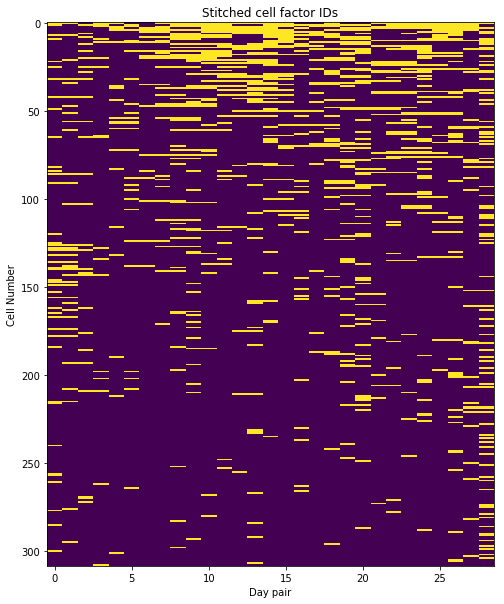

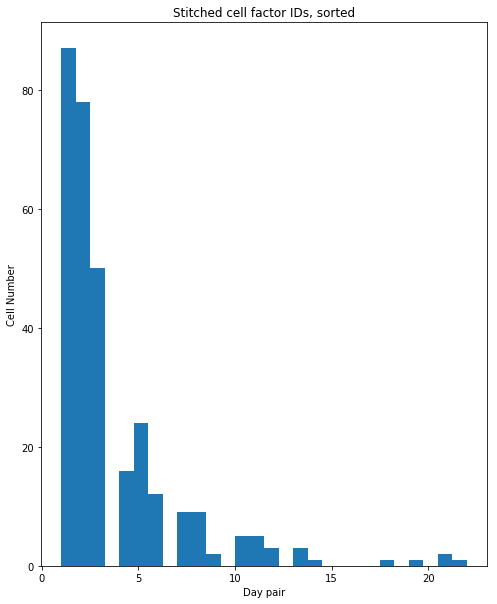

In [65]:
plt.figure(figsize=(8,10))
empties = np.mean(map > 0.05,1)
clean_map = map[empties > 0,:]
sort_cells = np.argsort(np.sum(map[empties > 0,:] > 0,1)*-1)
plt.imshow(clean_map[sort_cells,:] > 0, interpolation='nearest', aspect='auto')
# plt.imshow
plt.xlabel('Day pair')
plt.ylabel('Cell Number')
plt.title('Stitched cell factor IDs')

sort_map = clean_map[sort_cells,:]
for i in range(len(sort_cells)):
    sort_map[i, :] = np.sort(sort_map[i, :])
plt.figure(figsize=(8,10))
# plt.imshow(sort_map > 0, interpolation='nearest', aspect='auto')
plt.hist(np.sum(sort_map>0,1),28)
plt.xlabel('Day pair')
plt.ylabel('Cell Number')
plt.title('Stitched cell factor IDs, sorted')



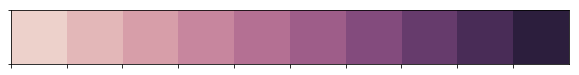

In [118]:
sns.palplot(sns.cubehelix_palette(10))

In [ ]:
# plotting options for the unconstrained and nonnegative models.
plot_options = {
  'cp_als': {
    'line_kw': {
      'color': 'red',
      'label': 'cp_als',
    },
    'scatter_kw': {
      'color': 'green',
      'alpha': 0.5,
    },
    'bar_kw': {
      'color': 'blue',
      'alpha': 0.5,
    },
  },
  'ncp_hals': {
    'line_kw': {
      'color': 'red',
      'label': 'ncp_hals',
    },
    'scatter_kw': {
      'color': 'green',
      'alpha': 0.5,
    },
    'bar_kw': {
      'color': 'blue',
      'alpha': 0.5,
    },
  },
  'ncp_bcd': {
    'line_kw': {
      'color': 'red',
      'label': 'ncp_bcd',
    },
    'scatter_kw': {
      'color': 'green',
      'alpha': 0.5,
    },
    'bar_kw': {
      'color': 'blue',
      'alpha': 0.5,
    },
  },
}

In [ ]:

for r in sort_ensemble.results:

    U = sort_ensemble.results[r][0].factors

    fig, axes = plt.subplots(U.rank, U.ndim + extra_col,
                             figsize=(9 + extra_col, U.rank))
    figt = tt.plot_factors(U, plots=['bar', 'line', 'scatter'],
                           axes=None,
                           fig=fig,
                           scatter_kw=plot_options[method]['scatter_kw'],
                           line_kw=plot_options[method]['line_kw'],
                           bar_kw=plot_options[method]['bar_kw'])
    ax = figt[0].axes
    ax[0].set_title('Neuron factors')
    ax[1].set_title('Temporal factors')
    ax[2].set_title('Trial factors')

    # reshape for easier indexing
    ax = np.array(ax).reshape((U.rank, -1))

    for col in range(3, 3+extra_col):
        for i in range(U.rank):

            # get axis values
            y_lim = ax[i, 2].get_ylim()
            x_lim = ax[i, 2].get_xlim()
            y_ticks = ax[i, 2].get_yticks()
            y_tickl = ax[i, 2].get_yticklabels()
            x_ticks = ax[i, 2].get_xticks()
            x_tickl = ax[i, 2].get_xticklabels()

            # running
            if plot_running:
                scale_by = np.nanmax(speed)/y_lim[1]
                if not np.isnan(scale_by):
                    ax[i, col].plot(np.array(speed.tolist())/scale_by, color=[1, 0.1, 0.6, 0.2])
                    # , label='speed')

            # Orientation - main variable to plot
            if col == 3:
                ori_vals = [0, 135, 270]
                color_vals = [[0.28, 0.68, 0.93, alpha], [0.84, 0.12, 0.13, alpha],
                              [0.46, 0.85, 0.47, alpha]]
                for k in range(0, 3):
                    ax[i, col].plot(trial_num[orientation==ori_vals[k]],
                                    U.factors[2][orientation==ori_vals[k], i], 'o',
                                    label=str(ori_vals[k]), color=color_vals[k], markersize=2)
                if i == 0:
                    ax[i, col].set_title('Orientation')
                    ax[i, col].legend(bbox_to_anchor=(0.5,1.02), loc='lower center',
                                      borderaxespad=2.5)
            elif col == 4:
                cs_vals = ['plus', 'minus', 'neutral']
                cs_labels = ['plus', 'minus', 'neutral']
                color_vals = [[0.46, 0.85, 0.47, alpha], [0.84, 0.12, 0.13, alpha],
                              [0.28, 0.68, 0.93, alpha]];
                col = 4
                for k in range(0,3):
                    ax[i, col].plot(trial_num[condition==cs_vals[k]],
                                                   U.factors[2][condition==cs_vals[k], i], 'o',
                                                   label=str(cs_labels[k]), color=color_vals[k], markersize=2)
                if i == 0:
                    ax[i, col].set_title('Condition')
                    ax[i, col].legend(bbox_to_anchor=(0.5,1.02), loc='lower center',
                                      borderaxespad=2.5)
            elif col == 5:
                trialerror_vals = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                trialerror_labels = ['hit',
                                     'miss',
                                     'neutral correct reject',
                                     'neutral false alarm',
                                     'minus correct reject',
                                     'minus false alarm',
                                     'blank correct reject',
                                     'blank false alarm',
                                     'pav early licking',
                                     'pav late licking',]
                for k in trialerror_vals:
                    ax[i, col].plot(trial_num[trialerror==trialerror_vals[k]],
                                    U.factors[2][trialerror==trialerror_vals[k], i], 'o',
                                    label=str(trialerror_labels[k]), alpha=0.8, markersize=2)
                if i == 0:
                    ax[i, col].set_title('Trialerror')
                    ax[i, col].legend(bbox_to_anchor=(0.5,1.02), loc='lower center',
                                      borderaxespad=2.5)

            elif col == 6:
                h_vals = ['hungry', 'sated', 'disengaged']
                h_labels = ['hungry', 'sated', 'disengaged']
                color_vals = [[1, 0.6, 0.3, alpha], [0.7, 0.9, 0.4, alpha],
                              [0.6, 0.5, 0.6, alpha], [0.0, 0.9, 0.4, alpha]]
                for k in range(0,3):
                    ax[i, col].plot(trial_num[hunger==h_vals[k]],
                                    U.factors[2][hunger==h_vals[k], i], 'o',
                                    label=str(h_labels[k]), color=color_vals[k], markersize=2)
                if i == 0:
                    ax[i, col].set_title('State')
                    ax[i, col].legend(bbox_to_anchor=(0.5,1.02), loc='lower center',
                                      borderaxespad=2.5)

            # set axes labels
            ax[i, col].set_yticks(y_ticks)
            ax[i, col].set_yticklabels(y_tickl)
            ax[i, col].set_ylim(y_lim)
            ax[i, col].set_xlim(x_lim)

            # format axes
            ax[i, col].locator_params(nbins=4)
            ax[i, col].spines['top'].set_visible(False)
            ax[i, col].spines['right'].set_visible(False)
            ax[i, col].xaxis.set_tick_params(direction='out')
            ax[i, col].yaxis.set_tick_params(direction='out')
            ax[i, col].yaxis.set_ticks_position('left')
            ax[i, col].xaxis.set_ticks_position('bottom')

            # remove xticks on all but bottom row
            if i + 1 != U.rank:
                plt.setp(ax[i, col].get_xticklabels(), visible=False)

            if col == 3:
                ax[i, 0].set_ylabel('Component #' + str(i+1), rotation=0,
                  labelpad=45, verticalalignment='center', fontstyle='oblique')

    if filetype.lower() == 'pdf':
        suffix = '.pdf'
    elif filetype.lower() == 'eps':
        suffix = '.eps'
    else:
        suffix = '.png'
    plt.savefig(os.path.join(date_dir, 'rank_' + str(int(r)) + suffix),
                             bbox_inches='tight')
    if verbose:
        plt.show()
    plt.close()
